# В этом ноутбуке представлена первая гипотеза для оценки сходства датасетов, а также реализован метод сравнения датасетов в соответствии с первой гипотезой.

**Первая гипотеза** для метода оценки сходства датасетов:

_Сходство датасетов может быть связано со схожестью их текстового содержания, которое отражается в схожести часто встречающихся в датасетах слов._

----------------

Поэтому **метод сравнения датасетов** заключается в следующем:

Посчитать наиболее часто встречающиеся слова (исключив предлоги и артикли, которые могут встречаться часто, но при этом не оказывать существенного влияния на смысл текста) в каждом из датасетов и оставить, например, топ из _num_:=100 наиболее часто встречающихся слов. Для каждого датасета этот топ будет свой. Затем оценить, насколько похожи эти топы слов: 
для каждого слова из первого топа найти максимум similarity(рассматриваемое_фиксированное_слово_из_первого_топа, слово_из_второго_топа) по всем возможным значениям переменной слово_из_второго_топа. Проще говоря, для каждого слова из первого топа найти наиболее схожее слово из второго топа; после чего запомнить число, соответствующее степени их схожести. 

Для каждого слова из первого топа получится какое-то значение максимума similarity.  Следует сложить эти значения. Чем больше полученная сумма, тем более вероятно сходство датасетов.

Разумеется, можно брать _num_ равным не 100, а, например, 200 или 1000. Так как не ясно, какое значение _num_ даст наилучшие результаты, то следует провести вычисления для различных значений _num_.



In [1]:
hotel_reviews = 'hotel reviews'
movie_reviews = 'movie reviews'
spam_sms = 'spam sms'
spam_emails = 'spam emails'

datasets_names = [hotel_reviews, movie_reviews, spam_sms, spam_emails]

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
from collections import Counter
import re
import nltk
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='deep')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Mounted at /content/drive


In [3]:
flag_need_to_conduct_research_for_different_num_values = False  # флаг, соответствующий тому, следует ли считать датафреймы для различных значений num.
# Если выставить False, то это сэкономит время, результаты исследования будут взяты из Google Drive (куда записаны результаты ранее проведенного исследования).
flag_need_to_save_dataframes_to_google_drive = False  # флаг, соответствующий тому, следует ли сохранять в Google Drive полученные датафреймы.
# В первый раз его следует выставить True, в последнующем – допустимо выставить False.

In [4]:
if flag_need_to_conduct_research_for_different_num_values:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    import gensim.downloader as api
    wv = api.load('word2vec-google-news-300')

In [5]:
def get_dataset_in_correct_form(dataset_name):
    if dataset_name == spam_sms:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/spam_sms.csv', encoding = "ISO-8859-1")
        df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
        df.columns = ['IS_SPAM', 'DATA_COLUMN']
        df['IS_SPAM'] = (df['IS_SPAM'] == 'spam').astype(int)
        df_positive = df[df['IS_SPAM']==1]
        df_negative = df[df['IS_SPAM']==0]
        # Тестовая выборка
        n_test = df_negative.shape[0] // 2
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 2
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 2
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 2
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    elif dataset_name == spam_emails:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/spam_emails.csv', encoding = "ISO-8859-1")
        df.drop(columns=['Unnamed: 0', 'label'], inplace=True)
        df.columns = ['DATA_COLUMN', 'IS_SPAM']
        df['DATA_COLUMN'] = df['DATA_COLUMN'].apply(lambda x: x.replace('\r\n', ' ').replace('\n', ' '))
        df_positive = df[df['IS_SPAM']==1]
        df_negative = df[df['IS_SPAM']==0]
        # Тестовая выборка
        n_test = df_negative.shape[0] // 2
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 2
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 2
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 2
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    elif dataset_name == hotel_reviews:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/tripadvisor_hotel_reviews.csv')
        df = df[df.Rating != 3]
        df['is_positive'] = (df['Rating'] >= 4).astype(int)
        df.drop(columns=['Rating'], inplace=True)
        df.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
        df_positive = df[df['LABEL_COLUMN']==1]
        df_negative = df[df['LABEL_COLUMN']==0]
        # Тестовая выборка
        n_test = (df_negative.shape[0] // 4) * 3
        df_negative_test = df_negative.tail(n_test)
        n_test = (df_positive.shape[0] // 20) * 3
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 4
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 20
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])
    
    elif dataset_name == movie_reviews:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/IMDB Dataset.csv')
        df['is_positive'] = (df['sentiment'] == 'positive').astype(int)
        df.drop(columns=['sentiment'], inplace=True)
        df.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
        df_positive = df[df['LABEL_COLUMN']==1]
        df_negative = df[df['LABEL_COLUMN']==0]
        # Для тестовой выборки берем последние 10% негативных отзывов и последние 10% позитивных отзывов
        n_test = df_negative.shape[0] // 10 # в оригинале df_negative.shape[0] // 10
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 10 # df_positive.shape[0] // 10
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Для обучающей выборки берем первые 2.5% из начала датасета.
        n_train = df_negative.shape[0] // 40 # в оригинале df_negative.shape[0] // 40
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 40 # в оригианале df_positive.shape[0] // 40
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    else:
        raise ValueError('Wrong dataset name')

    X_train = df_balanced_train['DATA_COLUMN'].squeeze()
    X_test = df_balanced_test['DATA_COLUMN'].squeeze()
    dataset_in_correct_form = pd.concat([X_train, X_test])
    return dataset_in_correct_form

In [6]:
def is_good_tag(tag):
    # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    # проверяем, что слово является прилагательным, существительным, наречием или глаголом
    return tag[:2] == 'JJ' or tag == 'NN' or tag == 'NNS' or tag[:2] == 'RB' or tag[:2] == 'VB'

def get_important_words(tagged):
    words_to_remove = ['is', 'am', 'are', 'i', 'he', 'she', 'it', 'was', 'were', 'have', 'has', 'had', 'ect', 'hou']
    important_words_to_return = []
    for word_and_tag in tagged:
        if is_good_tag(word_and_tag[1]) and (word_and_tag[0] not in words_to_remove) and len(word_and_tag[0]) > 2:
            important_words_to_return.append(word_and_tag[0])
    return important_words_to_return


def get_most_common_words_from_dataset(dataset, num=100):
    # убираем ненужное, считаем число встречаний каждого слова в counter
    TOKEN = re.compile(r'(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))')
    list_of_words_from_dataset = [word for item in dataset for word in re.findall(TOKEN, item)]
    counter = Counter(list_of_words_from_dataset)

    tokens = list(counter.keys())
    tagged = nltk.pos_tag(tokens)

    # оставим только наиболее значимые слова (в данном случае – существительные, глаголы, прилагательные и наречия)
    counter_with_important_words = Counter()
    for word in get_important_words(tagged):
        counter_with_important_words[word] = counter[word]
    # находим наиболее часто встречающиеся важные слова
    most_common_words = []
    for word_and_num_of_occurrences in counter_with_important_words.most_common(num):
        most_common_words.append(word_and_num_of_occurrences[0])
    return most_common_words



def get_similarity_of_lists_of_most_common_words(most_common_words_first_list, most_common_words_second_list):
    sum_of_similarities = 0

    for first_dataset_word in most_common_words_first_list:
        maximum_of_similarity = 0
        for second_dataset_word in most_common_words_second_list:
            # вычисляем сходство слов
            if first_dataset_word == second_dataset_word:
                current_similarity = 1
            elif first_dataset_word in wv.vocab and second_dataset_word in wv.vocab:
                current_similarity = wv.similarity(first_dataset_word, second_dataset_word)
            else:
                # слова различаются, и хотя бы одного из этих слов нет в словаре ––> в этом случае считаем сходство равным нулю
                current_similarity = 0
            # обновляем максимум
            maximum_of_similarity = max(maximum_of_similarity, current_similarity)
        sum_of_similarities += maximum_of_similarity
    return sum_of_similarities

In [7]:
def calculate_datasets_similarity(first_dataset_name_local, second_dataset_name_local, num=100):

    first_dataset_in_correct_form = get_dataset_in_correct_form(first_dataset_name_local)
    second_dataset_in_correct_form = get_dataset_in_correct_form(second_dataset_name_local)

    most_common_words_of_first_dataset = get_most_common_words_from_dataset(first_dataset_in_correct_form, num)
    most_common_words_of_second_dataset = get_most_common_words_from_dataset(second_dataset_in_correct_form, num)

    result_similarity = get_similarity_of_lists_of_most_common_words(most_common_words_of_first_dataset, most_common_words_of_second_dataset)

    return result_similarity

In [8]:
# flag_need_to_conduct_research_for_different_num_values = False  # Уже был выставлен ранее 

Если в ячейке выше поставить True, то в ячейке ниже будет запущено трудоемкое по времени вычисление результатов сравнения датасетов при различных num. Чтобы не проводить эти вычисления много раз, я (после проведения вычислений в первый раз) сохраняю результаты вычислений в Google Drive. При последующих запусках ноутбука я загружаю результаты вычислений из Google Drive.


In [9]:
list_of_nums = [10, 20, 40, 80, 160, 320, 640, 900, 1280, 1800, 2560]

if flag_need_to_conduct_research_for_different_num_values:
    list_of_df_with_first_method_results = list()
    for num in list_of_nums:
        print('Research for num =', num, 'just started!')
        _i = 0
        cur_df_with_first_method_results = pd.DataFrame(columns=[hotel_reviews, movie_reviews, spam_sms, spam_emails])
        for cur_first_dataset in datasets_names:
            for cur_second_dataset in datasets_names:
                _i += 1
                print(_i, 'out of', len(datasets_names) ** 2, ':', "Please, be patient! Working on comparing", cur_first_dataset, 'with', cur_second_dataset)
                cur_df_with_first_method_results.loc[cur_first_dataset, cur_second_dataset] = calculate_datasets_similarity(cur_first_dataset, cur_second_dataset, num)
        list_of_df_with_first_method_results.append(cur_df_with_first_method_results)

    # сохраним в гугл диск полученные датафреймы
    for i in range(len(list_of_df_with_first_method_results)):
        cur_num = list_of_nums[i]
        list_of_df_with_first_method_results[i].to_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_with_num_' + str(cur_num) + '.csv')
else:
    list_of_df_with_first_method_results = [0] * len(list_of_nums)
    # загрузим из гугл-диска сохраненные датафреймы
    for i in range(len(list_of_df_with_first_method_results)):
        cur_num = list_of_nums[i]
        list_of_df_with_first_method_results[i] = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_with_num_' + str(cur_num) + '.csv')
        list_of_df_with_first_method_results[i].set_index('Unnamed: 0', inplace=True)
        list_of_df_with_first_method_results[i].index.names = [None]

In [10]:
list_of_df_with_first_method_results[10]

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,2560.000000,1891.498019,1873.391097,1775.988819
movie reviews,1946.240497,2560.000000,1916.523626,1793.601138
spam sms,1788.308951,1792.895662,2560.000000,1720.540329
spam emails,1678.324324,1633.705862,1696.616522,2560.000000


In [11]:
list_of_df_with_first_method_results[0]

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,10.000000,5.369096,4.672077,3.672123
movie reviews,5.907615,10.000000,5.322802,4.414048
spam sms,5.909298,5.994716,10.000000,4.910825
spam emails,2.468662,2.488150,2.654809,10.000000


Для удобства приведем датафреймы к схожему виду: поделим все значения в датафрейме на соответствующее этому датафрейму значение num и выразим полученное отношение в процентах:

In [12]:
list_of_df_with_first_method_results_in_percent = []
for i in range(len(list_of_df_with_first_method_results)):
    list_of_df_with_first_method_results_in_percent.append(list_of_df_with_first_method_results[i].copy())
    for cur_first_dataset in datasets_names:
        for cur_second_dataset in datasets_names:
            list_of_df_with_first_method_results_in_percent[i].loc[cur_first_dataset, cur_second_dataset] *= 100 / list_of_nums[i]    
    if flag_need_to_save_dataframes_to_google_drive:
        list_of_df_with_first_method_results_in_percent[i].to_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_in_percent_with_num_' + str(list_of_nums[i]) + '.csv')


In [13]:
list_of_df_with_first_method_results_in_percent[0]  # соответствует num = 10  

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,100.000000,53.690960,46.720768,36.721231
movie reviews,59.076150,100.000000,53.228018,44.140480
spam sms,59.092985,59.947162,100.000000,49.108251
spam emails,24.686621,24.881501,26.548091,100.000000


In [14]:
list_of_df_with_first_method_results_in_percent[10]  # соответствует num = 2560  

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,100.000000,73.886641,73.179340,69.374563
movie reviews,76.025019,100.000000,74.864204,70.062544
spam sms,69.855818,70.034987,100.000000,67.208607
spam emails,65.559544,63.816635,66.274083,100.000000


## Исследование эффективности метода для сходства датасетов в первом смысле (про перенос качества)

In [15]:
model_names_lower_case_list = ['albert', 'bert', 'distilbert', 'electra', 'labse', 'lambert', 'mobilebert', 'roberta', 'talkheads_ggelu_bert', 'tn_bert']

In [16]:
def get_df_from_first_series_of_experiments(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_series_of_experiments/' + df_name + '.csv')
    cur_df.set_index('Unnamed: 0', inplace=True)
    cur_df.index.names = [None]
    return cur_df


In [17]:
def get_df_from_second_series_of_experiments(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/second_series_of_experiments/' + df_name + '.csv')
    cur_df.set_index('Unnamed: 0', inplace=True)
    cur_df.index.names = [None]
    return cur_df

In [18]:
def get_f1_score_values_from_df_from_first_series_of_experiments(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_series_of_experiments/' + df_name + '.csv')
    cur_df.set_index('Unnamed: 0', inplace=True)
    cur_df.index.names = [None]
    def get_without_spaces(arr):
        new_arr = np.array([])
        for el in arr:
            if el != ' ':
                new_arr = np.append(new_arr, float(el))
        return new_arr
    return get_without_spaces(cur_df.f1_score.values)


In [19]:
get_df_from_first_series_of_experiments('df_with_train_quality_all_models')

,accuracy,precision,recall,f1_score
ALBERT,,,,
albert trained on hotel reviews quality on train dataset,0.7656,0.7713,0.7334,0.7518726922310095
albert trained on movie reviews quality on train dataset,0.6408,0.6333,0.6688,0.6505660701943015
BERT,,,,
bert trained on hotel reviews quality on train dataset,0.8035,0.7971,0.7971,0.7970999999999999
bert trained on movie reviews quality on train dataset,0.6864,0.6676,0.7424,0.7030159432624113
DistilBERT,,,,
distilbert trained on hotel reviews quality on train dataset,0.9062,0.9021,0.9045,0.9032984058452341
distilbert trained on movie reviews quality on train dataset,0.812,0.8272,0.7888,0.8075437623762375
ELECTRA,,,,


In [20]:
def get_single_f1_score_value_from_df_from_train_quality_folder(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/train_quality/' + df_name + '.csv')
    return cur_df.f1_score.values[0]

# Случай 1: рассматриваются все возможные пары датасетов, в том числе пары с совпадающими датасетами.

In [40]:
first_series_of_experiments_datasets = [hotel_reviews, movie_reviews]
second_series_of_experiments_datasets = [spam_sms, spam_emails]

list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()

    # first series of experiments
    for first_dataset in first_series_of_experiments_datasets:
        for second_dataset in first_series_of_experiments_datasets:
            if True: # можно выбрать, использовать это условие или условие ниже. Для второй серии экспериментов должно быть выбрано то же условие, что и здесь
            # if first_dataset != second_dataset: # можно выбрать, использовать это условие или условие выше
                # Получим список с абсолютным изменение качества для фиксированной пары датасетов,
                # итерируемся по всем моделям.
                list_of_absolute_differences_for_fixed_pair_of_datasets = list()
                list_of_relative_differences_for_fixed_pair_of_datasets = list()
                for model_name in model_names_lower_case_list:
                    # absolute quality difference
                    cur_df = get_df_from_first_series_of_experiments('df_with_absolute_quality_difference')
                    index_name = model_name + ' trained on ' + first_dataset + ' and tested on ' + second_dataset + ' dataset quality difference'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

                    # relative quality difference
                    cur_df = get_df_from_first_series_of_experiments('df_with_relative_quality_difference_in_percent')
                    index_name = model_name + ' trained on ' + first_dataset + ' and tested on ' + second_dataset + ' dataset difference in percent'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_relative_differences_for_fixed_pair_of_datasets.append(difference)

                # absolute quality difference: mean result
                mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                mean_f1_score_value = np.average(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
                list_of_method_results.append(method_result)


    # second series of experiments
    for first_dataset in second_series_of_experiments_datasets:
        for second_dataset in second_series_of_experiments_datasets:
            if True: # можно выбрать, использовать это условие или условие ниже. Для певрой серии экспериментов должно быть выбрано то же условие, что и здесь
            # if first_dataset != second_dataset: # можно выбрать, использовать это условие или условие выше
                # Получим список с абсолютным изменение качества для фиксированной пары датасетов,
                # итерируемся по всем моделям.
                list_of_absolute_differences_for_fixed_pair_of_datasets = list()
                list_of_relative_differences_for_fixed_pair_of_datasets = list()
                for model_name in model_names_lower_case_list:
                    # absolute quality difference
                    cur_df = get_df_from_second_series_of_experiments('df_with_absolute_quality_difference')
                    index_name = model_name + ' trained on ' + first_dataset + ' tested on ' + second_dataset + ' dataset quality difference'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

                    # relative quality difference
                    cur_df = get_df_from_second_series_of_experiments('df_with_relative_quality_difference_in_percent')
                    index_name = model_name + ' trained on ' + first_dataset + ' tested on ' + second_dataset + ' dataset difference in percent'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_relative_differences_for_fixed_pair_of_datasets.append(difference)

                # absolute quality difference: mean result
                mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                mean_f1_score_value = np.average(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
                list_of_method_results.append(method_result)

    # Пусть теперь датасеты взяты из разных серий экспериментов, решаются разные задачи:
    # В датасетах из первой серии эскпериментов отзыв классифицируется как позитивный или негативный. 
    # В датасетах из второй серии экспериментов содержимое классифицируется как спам / не спам. 

    # Пункт 1: Здесь первый датасет из первой серии, второй датасет – из второй
    for first_dataset in first_series_of_experiments_datasets:
        for second_dataset in second_series_of_experiments_datasets:
            list_of_absolute_differences_for_fixed_pair_of_datasets = list()
            for model_name in model_names_lower_case_list:
                # На первом датасете (он из ПЕРВОЙ серии экспериментов) происходит обучение.
                # Для первой серии экспериментов качество на обучающей выброке сохранено
                cur_df = get_df_from_first_series_of_experiments('df_with_train_quality_all_models')
                index_name = model_name + ' trained on ' + first_dataset + ' quality on train dataset'
                # Считаем, что качество падает до нуля
                difference = -1 * float(cur_df.loc[index_name, 'f1_score'])
                list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

            # absolute quality difference: mean result
            mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
            # absolute quality difference: median result
            median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

            # relative quality difference: mean result
            list_of_mean_f1_score_relative_difference_values.append(-100)
            # relative quality difference: median result
            list_of_median_f1_score_relative_difference_values.append(-100)
            method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
            list_of_method_results.append(method_result)

    # Пункт 2: Здесь первый даатсет из второй серии, второй датасет – из первой серии
    for first_dataset in second_series_of_experiments_datasets:
        for second_dataset in first_series_of_experiments_datasets:
            list_of_absolute_differences_for_fixed_pair_of_datasets = list()
            for model_name in model_names_lower_case_list:
                # На первом датасете (он из ВТОРОЙ серии экспериментов) происходит обучение.
                # Для этой серии экспериментов качество на обучающей выброке сохранено в отдельной папке
                # Также считаем, что качество падает до нуля
                difference = -1 * get_single_f1_score_value_from_df_from_train_quality_folder(
                    model_name + ' trained on ' + first_dataset + ' quality on train dataset'
                )
                list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)
            # absolute quality difference: mean result
            mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
            # absolute quality difference: median result
            median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)
            # relative quality difference: mean result
            list_of_mean_f1_score_relative_difference_values.append(-100)
            # relative quality difference: median result
            list_of_median_f1_score_relative_difference_values.append(-100)
            method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
            list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)

    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)
                

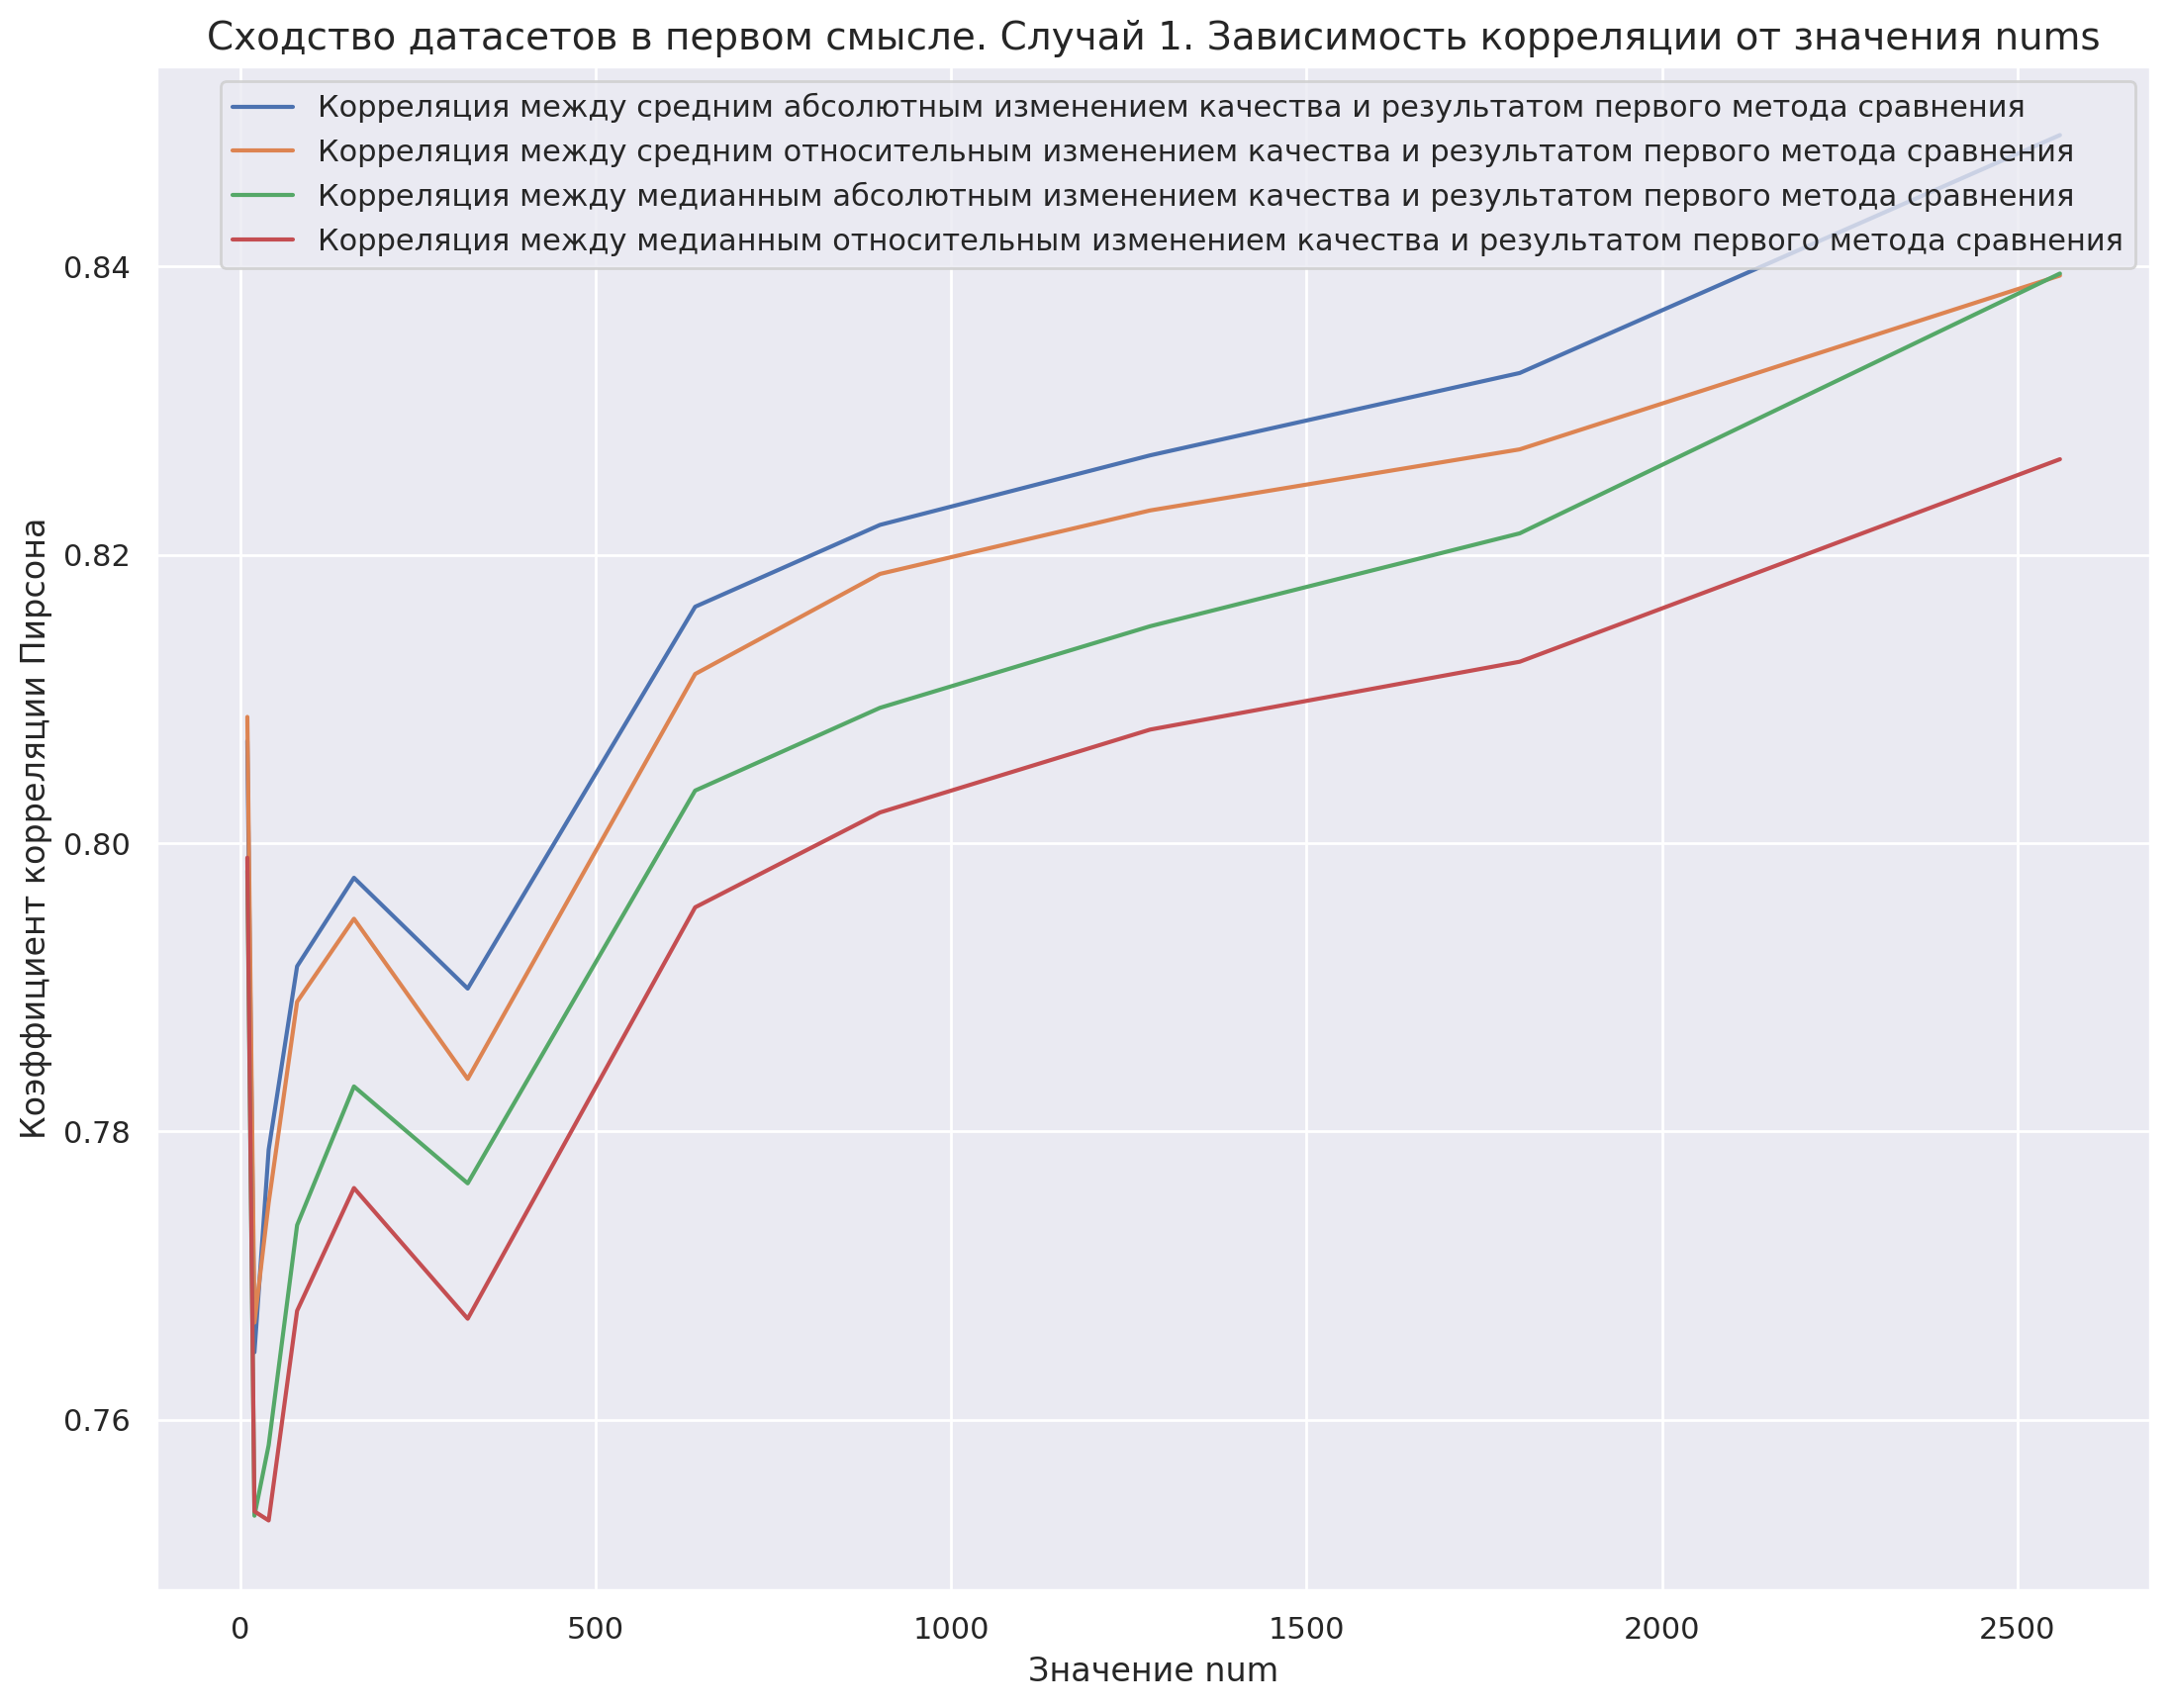

In [41]:
# написать для графиков разные заголовки
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
        label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Сходство датасетов в первом смысле. Случай 1. Зависимость корреляции от значения nums", fontsize=14)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

In [42]:
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result

[0.8070876219845223,
 0.7646822697321222,
 0.7787340304172404,
 0.7914561956483886,
 0.7975961950530577,
 0.789911863393761,
 0.8163979094613847,
 0.8220747473806251,
 0.8268989264636338,
 0.8326121173065935,
 0.8491155157787461]

In [43]:
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result

[0.808754061144067,
 0.7667380104448407,
 0.7750555544373917,
 0.7889929367469244,
 0.7947539894208372,
 0.783641394635227,
 0.8117316335156146,
 0.8186749445360747,
 0.8230783251185539,
 0.8273143717569821,
 0.8393725830278418]

In [44]:
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result

[0.798100316855901,
 0.7533437109875544,
 0.7582390536131782,
 0.7734984292506112,
 0.7831226598845235,
 0.7764018895444297,
 0.803644960865032,
 0.8093858098424406,
 0.8150446355909692,
 0.8214891247536786,
 0.8395115699451976]

In [45]:
list_of_correlations_for_median_relative_quality_difference_and_first_method_result

[0.7989895661411144,
 0.7536461427126082,
 0.7530141186138072,
 0.7675591811653538,
 0.7760767278025825,
 0.7670089575328906,
 0.795547732633173,
 0.8021275127264476,
 0.8078750105628348,
 0.8125829891289555,
 0.8266312161254489]

In [23]:
# argmax = np.argmax(list_of_correlations_for_median_absolute_quality_difference_and_first_method_result)
# print('Лучшие значения корреляции достигаются при num=', nu)

# Случай 2: рассматриваются все возможные пары _различных_ датасетов.


In [24]:
first_series_of_experiments_datasets = [hotel_reviews, movie_reviews]
second_series_of_experiments_datasets = [spam_sms, spam_emails]

list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()

    # first series of experiments
    for first_dataset in first_series_of_experiments_datasets:
        for second_dataset in first_series_of_experiments_datasets:
            # if True: # можно выбрать, использовать это условие или условие ниже. Для второй серии экспериментов должно быть выбрано то же условие, что и здесь
            if first_dataset != second_dataset: # можно выбрать, использовать это условие или условие выше
                # Получим список с абсолютным изменение качества для фиксированной пары датасетов,
                # итерируемся по всем моделям.
                list_of_absolute_differences_for_fixed_pair_of_datasets = list()
                list_of_relative_differences_for_fixed_pair_of_datasets = list()
                for model_name in model_names_lower_case_list:
                    # absolute quality difference
                    cur_df = get_df_from_first_series_of_experiments('df_with_absolute_quality_difference')
                    index_name = model_name + ' trained on ' + first_dataset + ' and tested on ' + second_dataset + ' dataset quality difference'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

                    # relative quality difference
                    cur_df = get_df_from_first_series_of_experiments('df_with_relative_quality_difference_in_percent')
                    index_name = model_name + ' trained on ' + first_dataset + ' and tested on ' + second_dataset + ' dataset difference in percent'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_relative_differences_for_fixed_pair_of_datasets.append(difference)

                # absolute quality difference: mean result
                mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                mean_f1_score_value = np.average(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
                list_of_method_results.append(method_result)


    # second series of experiments
    for first_dataset in second_series_of_experiments_datasets:
        for second_dataset in second_series_of_experiments_datasets:
            # if True: # можно выбрать, использовать это условие или условие ниже. Для певрой серии экспериментов должно быть выбрано то же условие, что и здесь
            if first_dataset != second_dataset: # можно выбрать, использовать это условие или условие выше
                # Получим список с абсолютным изменение качества для фиксированной пары датасетов,
                # итерируемся по всем моделям.
                list_of_absolute_differences_for_fixed_pair_of_datasets = list()
                list_of_relative_differences_for_fixed_pair_of_datasets = list()
                for model_name in model_names_lower_case_list:
                    # absolute quality difference
                    cur_df = get_df_from_second_series_of_experiments('df_with_absolute_quality_difference')
                    index_name = model_name + ' trained on ' + first_dataset + ' tested on ' + second_dataset + ' dataset quality difference'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

                    # relative quality difference
                    cur_df = get_df_from_second_series_of_experiments('df_with_relative_quality_difference_in_percent')
                    index_name = model_name + ' trained on ' + first_dataset + ' tested on ' + second_dataset + ' dataset difference in percent'
                    difference = float(cur_df.loc[index_name, 'f1_score'])
                    list_of_relative_differences_for_fixed_pair_of_datasets.append(difference)

                # absolute quality difference: mean result
                mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                mean_f1_score_value = np.average(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(list_of_relative_differences_for_fixed_pair_of_datasets)
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
                list_of_method_results.append(method_result)

    # Пусть теперь датасеты взяты из разных серий экспериментов, решаются разные задачи:
    # В датасетах из первой серии эскпериментов отзыв классифицируется как позитивный или негативный. 
    # В датасетах из второй серии экспериментов содержимое классифицируется как спам / не спам. 

    # Пункт 1: Здесь первый датасет из первой серии, второй датасет – из второй
    for first_dataset in first_series_of_experiments_datasets:
        for second_dataset in second_series_of_experiments_datasets:
            list_of_absolute_differences_for_fixed_pair_of_datasets = list()
            for model_name in model_names_lower_case_list:
                # На первом датасете (он из ПЕРВОЙ серии экспериментов) происходит обучение.
                # Для первой серии экспериментов качество на обучающей выброке сохранено
                cur_df = get_df_from_first_series_of_experiments('df_with_train_quality_all_models')
                index_name = model_name + ' trained on ' + first_dataset + ' quality on train dataset'
                # Считаем, что качество падает до нуля
                difference = -1 * float(cur_df.loc[index_name, 'f1_score'])
                list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)

            # absolute quality difference: mean result
            mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
            # absolute quality difference: median result
            median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

            # relative quality difference: mean result
            list_of_mean_f1_score_relative_difference_values.append(-100)
            # relative quality difference: median result
            list_of_median_f1_score_relative_difference_values.append(-100)
            method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
            list_of_method_results.append(method_result)

    # Пункт 2: Здесь первый даатсет из второй серии, второй датасет – из первой серии
    for first_dataset in second_series_of_experiments_datasets:
        for second_dataset in first_series_of_experiments_datasets:
            list_of_absolute_differences_for_fixed_pair_of_datasets = list()
            for model_name in model_names_lower_case_list:
                # На первом датасете (он из ВТОРОЙ серии экспериментов) происходит обучение.
                # Для этой серии экспериментов качество на обучающей выброке сохранено в отдельной папке
                # Также считаем, что качество падает до нуля
                difference = -1 * get_single_f1_score_value_from_df_from_train_quality_folder(
                    model_name + ' trained on ' + first_dataset + ' quality on train dataset'
                )
                list_of_absolute_differences_for_fixed_pair_of_datasets.append(difference)
            # absolute quality difference: mean result
            mean_f1_score_value = np.average(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
            # absolute quality difference: median result
            median_f1_score_value = np.median(list_of_absolute_differences_for_fixed_pair_of_datasets)
            list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)
            # relative quality difference: mean result
            list_of_mean_f1_score_relative_difference_values.append(-100)
            # relative quality difference: median result
            list_of_median_f1_score_relative_difference_values.append(-100)
            method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset, second_dataset]
            list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)

    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)

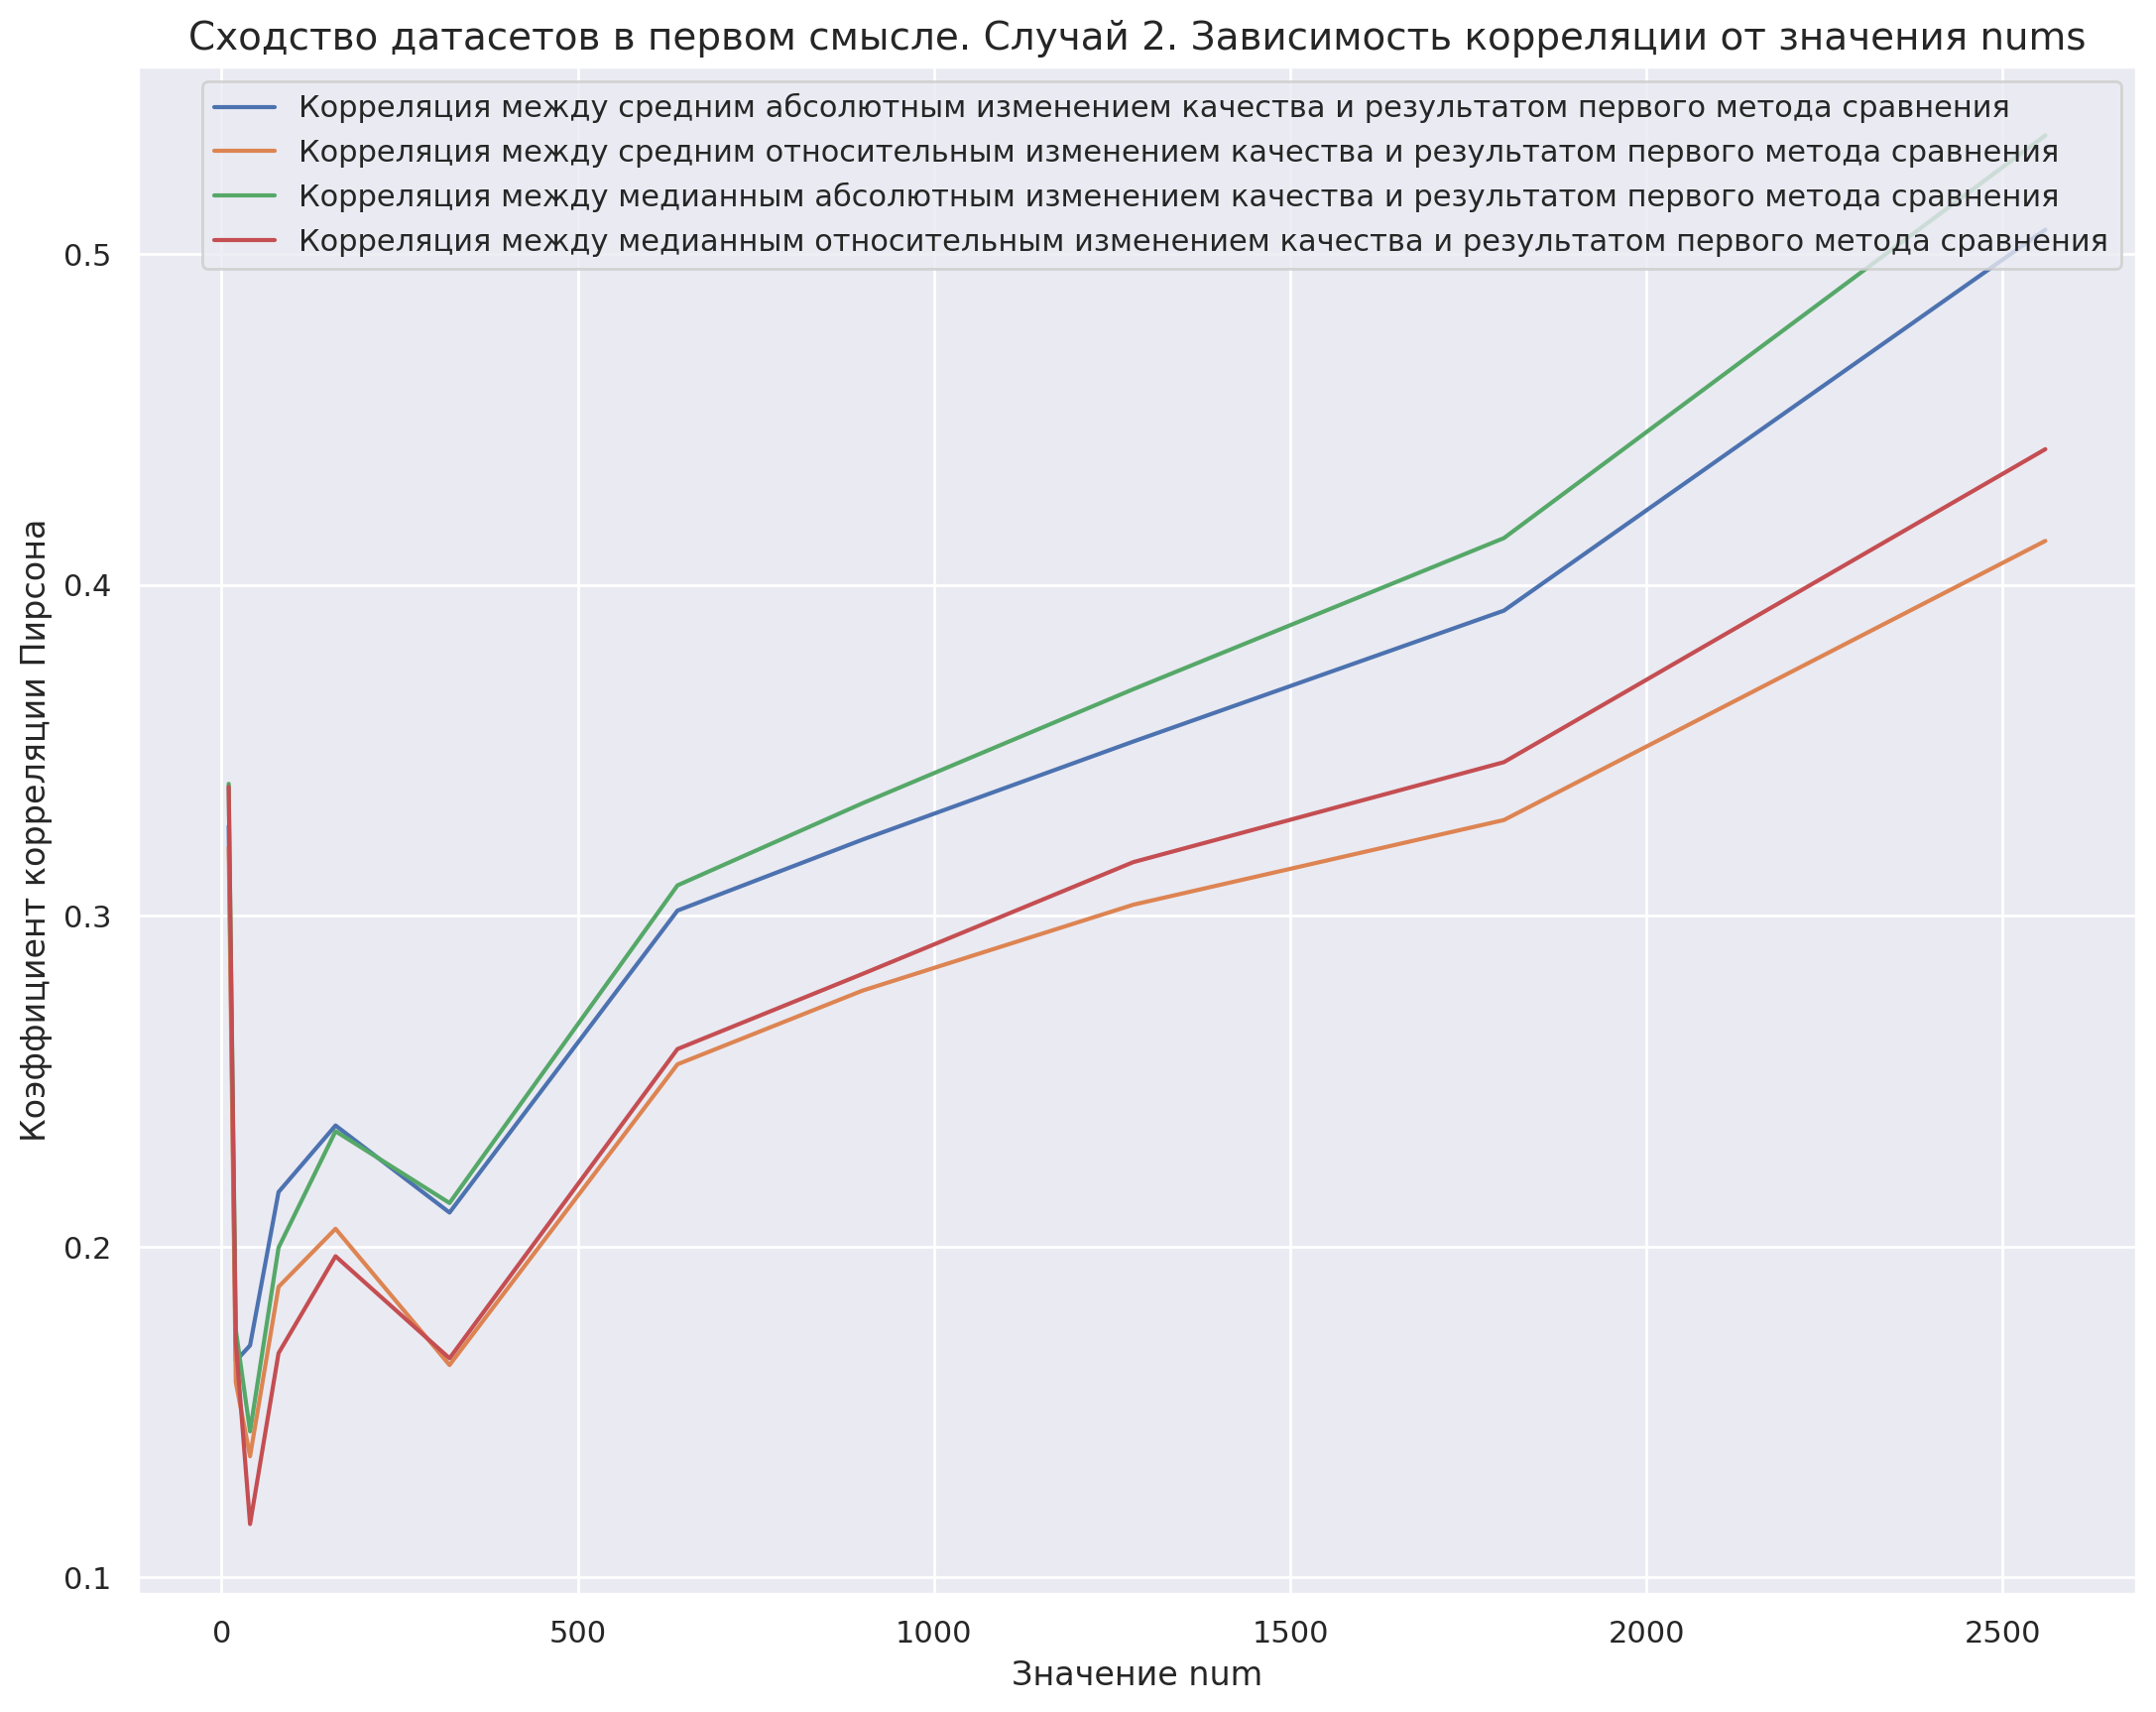

In [25]:
# написать для графиков разные заголовки
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
        label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Сходство датасетов в первом смысле. Случай 2. Зависимость корреляции от значения nums", fontsize=14)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

In [26]:
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result

[0.32712327218019605,
 0.16544428083940171,
 0.17015399422155697,
 0.21651360491397906,
 0.2366292958090669,
 0.21031013668078866,
 0.30158664518435924,
 0.32305267750168676,
 0.3526961913290777,
 0.3922374843764414,
 0.5073971865510936]

In [27]:
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result

[0.32071885091671587,
 0.15901486163702555,
 0.13665167441008572,
 0.1878632184880593,
 0.2054161720574598,
 0.16422507132643535,
 0.25512352580216674,
 0.27741666204334386,
 0.30336818980899566,
 0.32895107649629685,
 0.4133186797163889]

In [28]:
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result

[0.33990131427525044,
 0.17484490615559883,
 0.14417690601755487,
 0.19972415870555935,
 0.23489299420670506,
 0.21320098428030831,
 0.3092024107249454,
 0.3340522969599318,
 0.36851984772155794,
 0.41415919586966304,
 0.5358734022835296]

In [29]:
list_of_correlations_for_median_relative_quality_difference_and_first_method_result

[0.3389895529493699,
 0.17123286288216685,
 0.11617042433975022,
 0.16781511116044873,
 0.1971155678071633,
 0.16626185532926643,
 0.2597395202335063,
 0.28246437874804414,
 0.3162385024922462,
 0.346439546381643,
 0.4410347248515782]

# **Вывод:**
Среднее и медианное изменение абсолютного качества, среднее и медианное изменение относительного качества – все они ведут себя схожим образом для обоих случаев (см. случаи 1 и 2 выше).

*Для случая 1:*

Коэффициент корреляции, в зависимости от выбранного значения _num_ и того, какое конкретно изменение качества рассматривается, принимает значения от 0.75 до 0.85, то есть в целом корреляция высокая. Сначала с увеличением значения _num_ значение коэффициента корреляции несколько падает, потом немного колеблется, а затем растет. Оптимальным является _num_=2560, при котором значение коэффициента корреляции составляет от 0.82 до 0.85.


*Для случая 2:*

Коэффициент корреляции, в зависимости от выбранного значения _num_ и того, какое конкретно изменение качества рассматривается, принимает значения от 0.11 до 0.54. Сначала с увеличением значения _num_ значение коэффициента корреляции несколько падает, потом немного колеблется, а затем растет. Оптимальным также является _num_=2560, при котором значение коэффициента корреляции составляет от 
0.41 до 0.54.

Таким образом, при оптимальном значении _num_ корреляция получается средняя,  ближе к слабой, чем к высокой.


**Подводя итог, при оптимальном значении _num_ получается высокая корреляция для случая 1 и средняя корреляция для случая 2. Метод можно считать эффективным для оценки сходства датасетов в первом смысле.**

## Исследование эффективности метода для сходства датасетов во втором смысле

Случай 1: рассмотрим такиой набор пар датасетов, чтобы в нем была пара, соответствующая первой серии экспериментов, была пара, соответствующая второй серии экспериментов, а также были пары, соответствующие . Этот случай не включает переходы в обратную сторону, то есть здесь не все возможные пары датасетов.

In [32]:
def get_f1_score_values_from_df_from_additional_research(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/additional_research/' + df_name + '.csv')
    cur_df.set_index('Unnamed: 0', inplace=True)
    cur_df.index.names = [None]
    return cur_df.f1_score.values


In [33]:
def transform_name_of_dataset(dataset_name):
    if dataset_name in ['sms', 'emails']:
        return 'spam ' + dataset_name
    return dataset_name 

In [52]:
list_of_dataset_names_with_underscore = ['hotel_reviews', 'movie_reviews', 'spam_sms', 'spam_emails']
list_of_pairs_considered = ['hotel_reviews_to_movie_reviews', 'hotel_reviews_to_emails', 'hotel_reviews_to_sms',
                            'movie_reviews_to_emails', 'movie_reviews_to_sms', 'sms_to_emails']
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()
    for pair_of_datasets in list_of_pairs_considered:
        # absolute quality difference: mean result
        df_name = 'df_absolute_quality_difference_when_switching_from_' + pair_of_datasets
        mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
        list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
        # absolute quality difference: median result
        median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
        list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

        # relative quality difference: mean result
        df_name = 'df_relative_quality_difference_in_percent_when_switching_from_' + pair_of_datasets
        mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
        list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
        # relative quality difference: median result
        median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
        list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

        first_dataset_name, second_dataset_name = [transform_name_of_dataset(dataset_name.replace('_', ' ')) for dataset_name in pair_of_datasets.split('_to_')]

        method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset_name, second_dataset_name]
        list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)

    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)

Построить графики для всез списков сразу, чтобы понять, какой индекс (то есть число num) лучше:

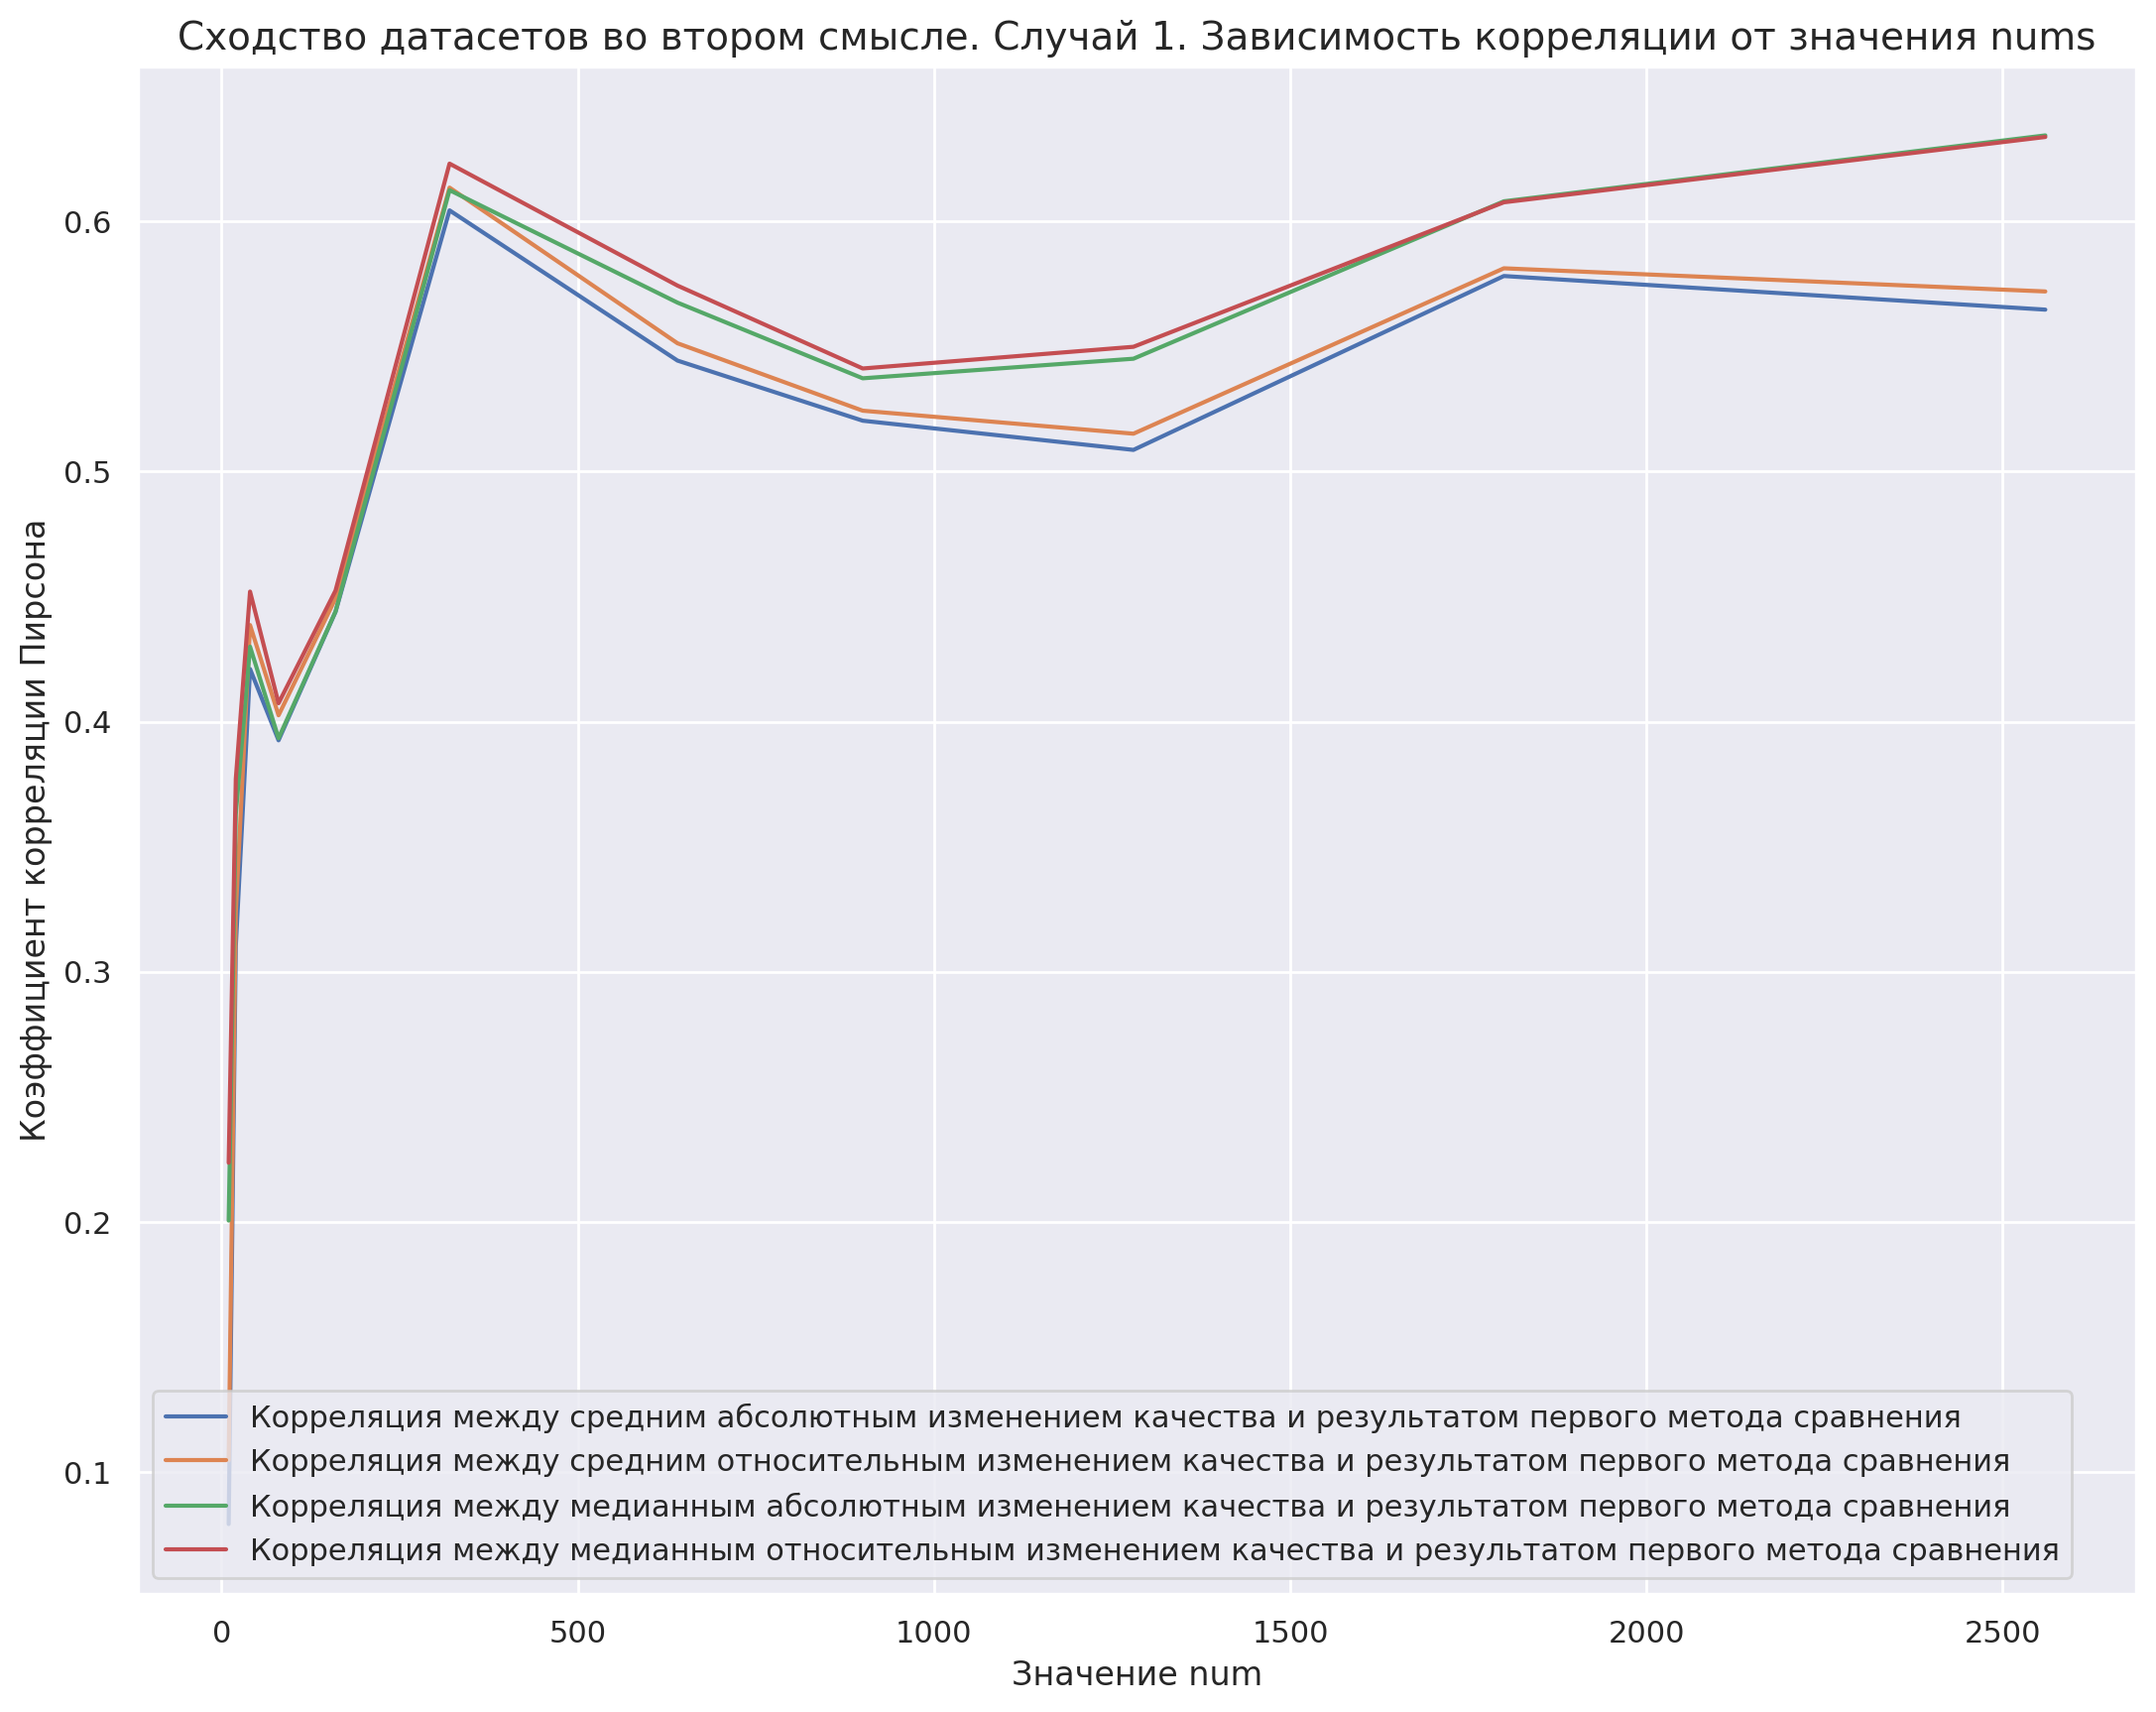

In [53]:
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
         label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Сходство датасетов во втором смысле. Случай 1. Зависимость корреляции от значения nums", fontsize=14)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

In [54]:
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result

[0.07932257027161475,
 0.31019279339466616,
 0.42103923768940943,
 0.3925421750801581,
 0.4439187380457371,
 0.6043400657878801,
 0.5443010428959139,
 0.520272166220839,
 0.508605069823416,
 0.5781031614766409,
 0.5646604045778586]

In [55]:
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result

[0.10477448442707434,
 0.3236702313627558,
 0.43859709712631595,
 0.4025379095995913,
 0.44926723408025876,
 0.6134306244022352,
 0.5512202177215442,
 0.5242720928824918,
 0.5150812916667644,
 0.5811839236750371,
 0.571928217179609]

In [56]:
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result

[0.20060151491428868,
 0.3629861847281947,
 0.4299734893757614,
 0.3933613026638041,
 0.444021638479224,
 0.612420598986808,
 0.567462449189459,
 0.5372205887370025,
 0.5450477016792885,
 0.6079548356505914,
 0.6342989751459571]

In [57]:
list_of_correlations_for_median_relative_quality_difference_and_first_method_result

[0.22372178339702678,
 0.3771446031628581,
 0.45197645464454406,
 0.40735590976545993,
 0.45240048826367435,
 0.623020081510504,
 0.5742665536719629,
 0.5411446514671787,
 0.5498113599069293,
 0.6075595834474903,
 0.633672547492217]

In [36]:
print(list_of_nums)

[10, 20, 40, 80, 160, 320, 640, 900, 1280, 1800, 2560]


# Вывод:
В целом, наилучшие результаты для сходства датасетов во втором смысле достигаются при *nums*=320 и при *nums*=2560.

------

Случай 2:

Добавим переход в другую сторону и посмотрим ПО ВСЕМ ПАРАМ ДАТАСЕТОВ, какая будет корреляция:

In [46]:
list_of_dataset_names_with_underscore = ['hotel_reviews', 'movie_reviews', 'spam_sms', 'spam_emails']

list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()
    for first_dataset_name in list_of_dataset_names_with_underscore:
        for second_dataset_name in list_of_dataset_names_with_underscore:
            if first_dataset_name != second_dataset_name:
                pair_of_datasets = first_dataset_name + '_to_' + second_dataset_name
                pair_of_datasets = pair_of_datasets.replace('spam_', '')

                # absolute quality difference: mean result
                df_name = 'df_absolute_quality_difference_when_switching_from_' + pair_of_datasets
                mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                df_name = 'df_relative_quality_difference_in_percent_when_switching_from_' + pair_of_datasets
                mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)
                
                first_dataset_name_without_underscore = first_dataset_name.replace('_', ' ')
                second_dataset_name_without_underscore = second_dataset_name.replace('_', ' ')
                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset_name_without_underscore, second_dataset_name_without_underscore]
                list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)




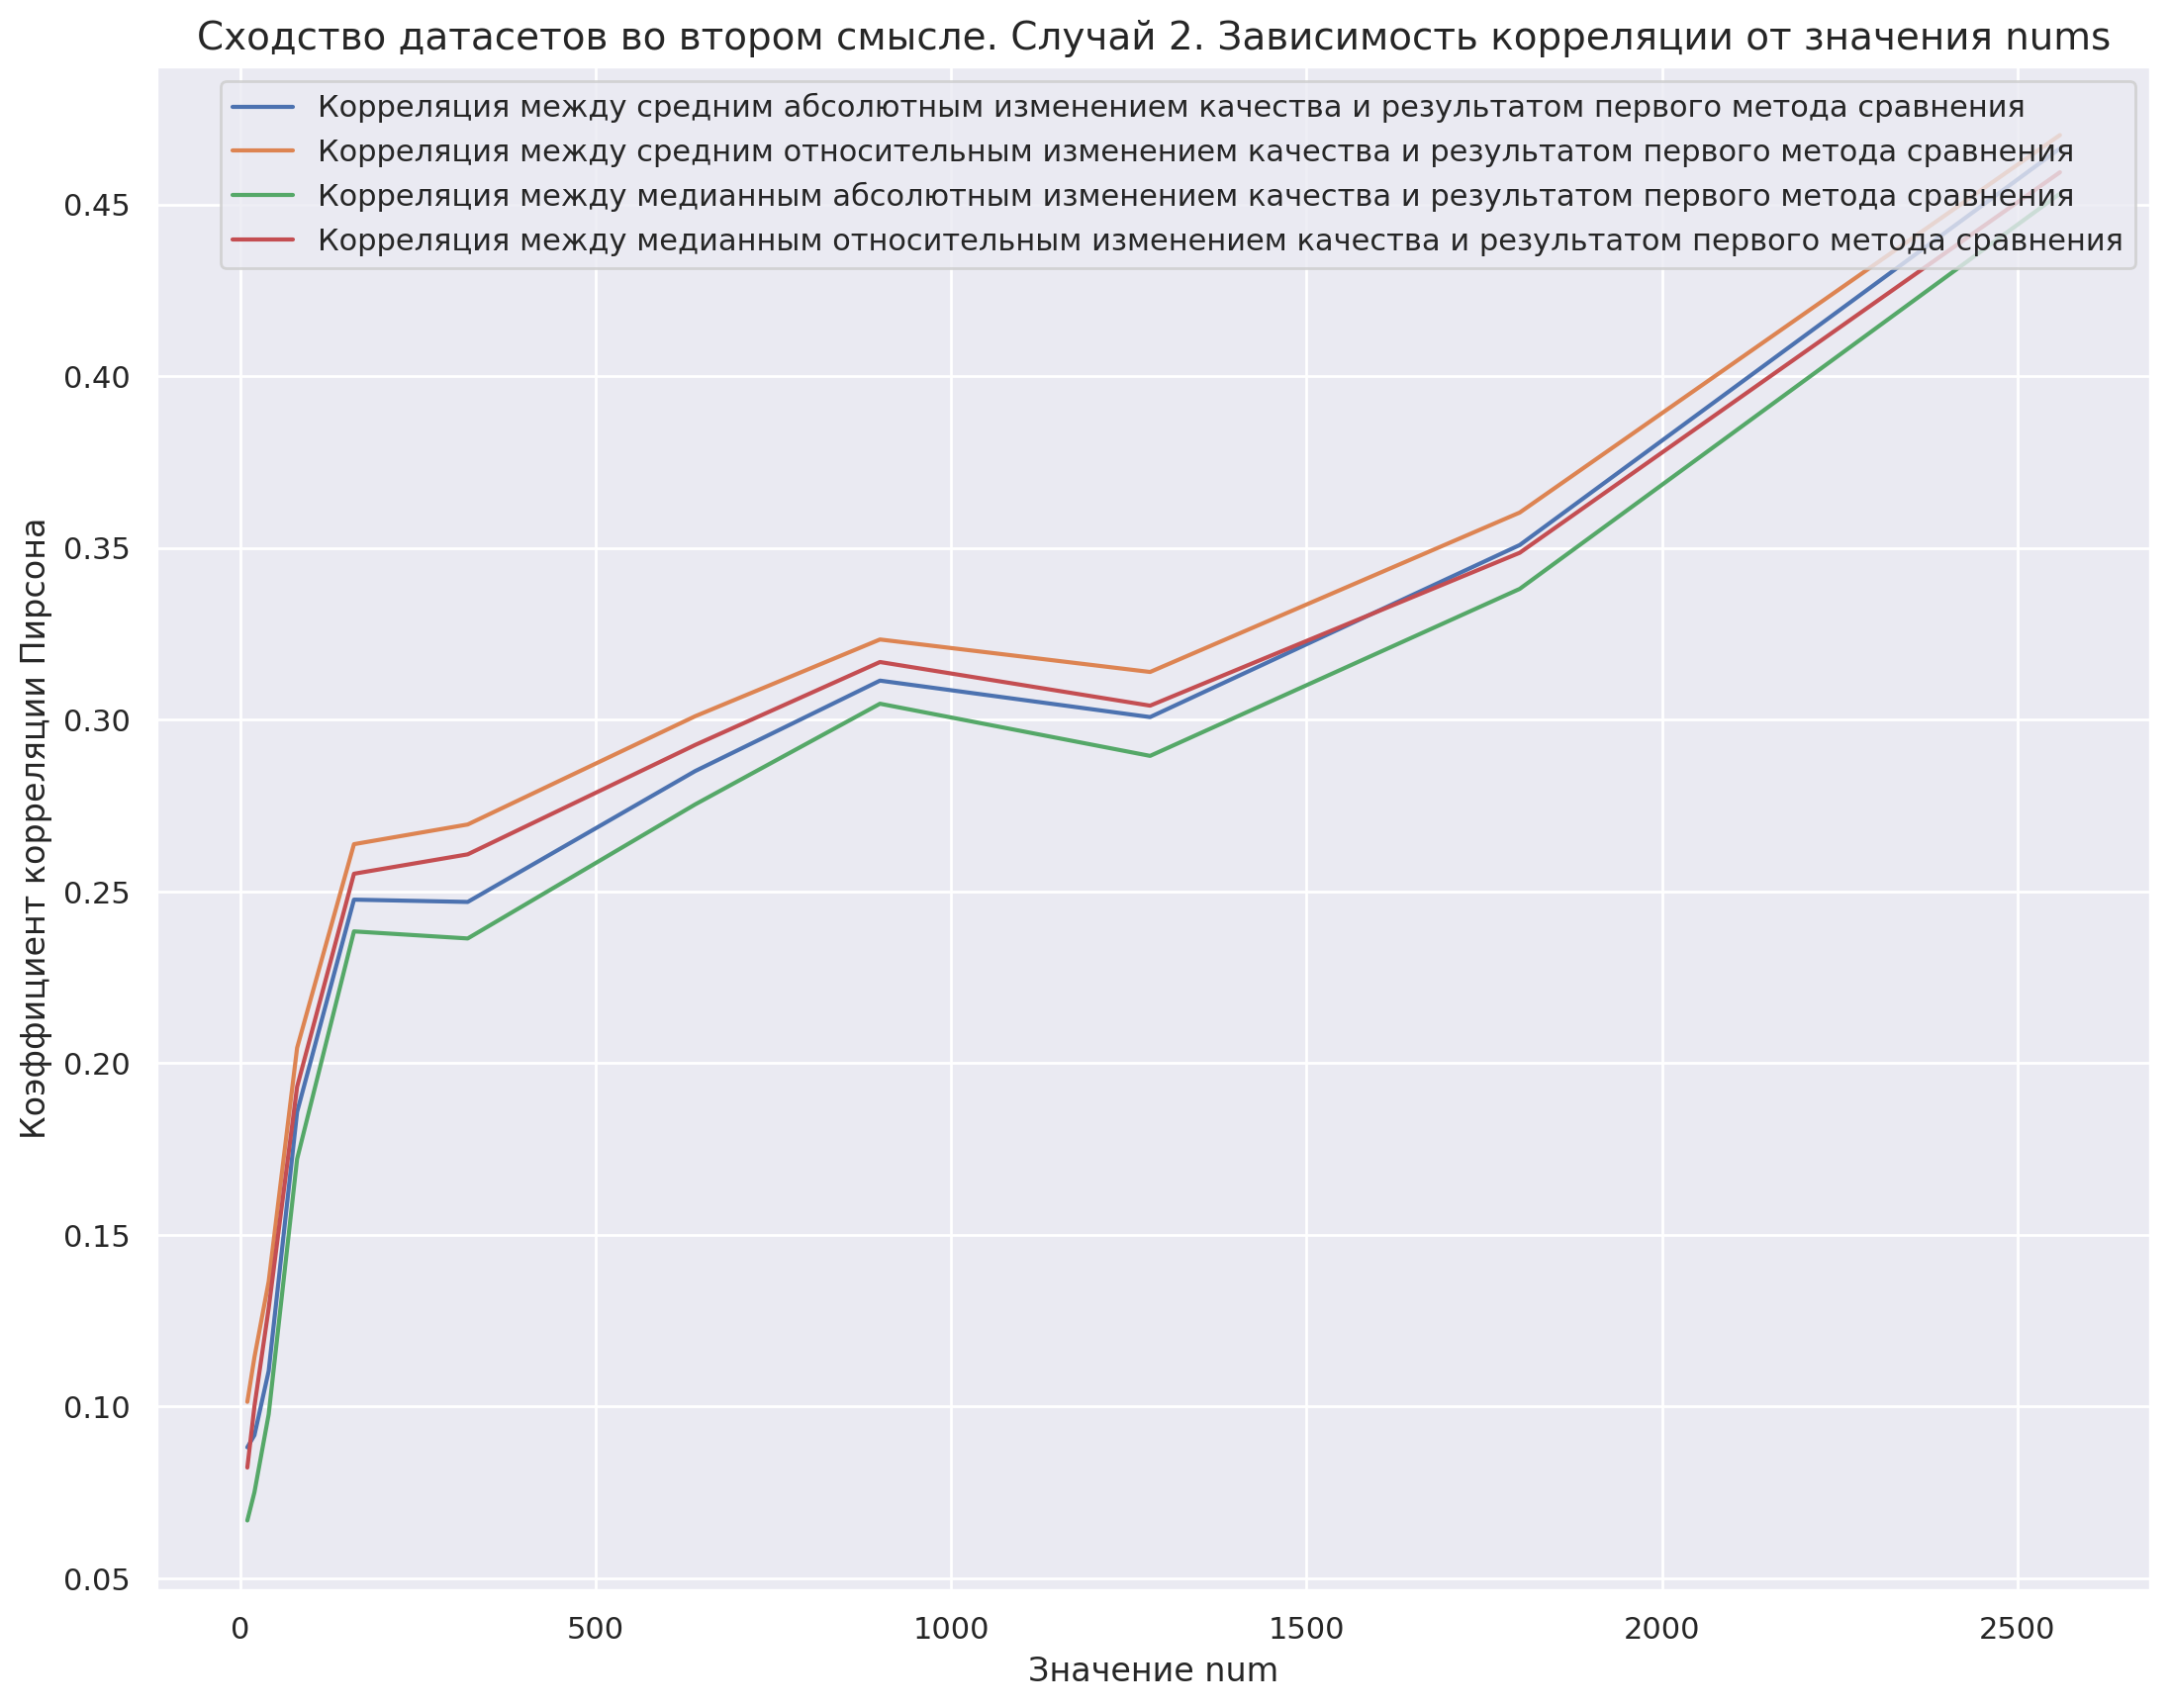

In [47]:
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
         label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Сходство датасетов во втором смысле. Случай 2. Зависимость корреляции от значения nums", fontsize=14)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

In [48]:
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result

[0.08816344084188965,
 0.09169634691967897,
 0.11036949203220257,
 0.1857826754203527,
 0.24761775008823894,
 0.24694696143822,
 0.2850475578551119,
 0.3113839591143867,
 0.30076688937891943,
 0.35085874662456706,
 0.4663556067718844]

In [49]:
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result

[0.10140194101230586,
 0.11438971614842368,
 0.13641994862473536,
 0.20446377182643205,
 0.26376878678748433,
 0.26949795371953034,
 0.30101516964777314,
 0.3233656172273525,
 0.31390475118339073,
 0.3603201815568686,
 0.47021970361442905]

In [50]:
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result

[0.06686147525070017,
 0.07508092405871598,
 0.09774435566871331,
 0.1720918178895908,
 0.23837283334632403,
 0.23631467602182207,
 0.2753443774569283,
 0.3046596002241514,
 0.2894708115497397,
 0.33809517819741747,
 0.4531760051035021]

In [51]:
list_of_correlations_for_median_relative_quality_difference_and_first_method_result

[0.08226806398810405,
 0.10012144429120666,
 0.12861123237521854,
 0.19312661926815816,
 0.2551593493091641,
 0.2608068251467647,
 0.2926547166017879,
 0.3168023077684001,
 0.3040969637575602,
 0.3486077158488495,
 0.4593933065721605]

# **Вывод:**
Для случаев 1 и 2 изменения качества (среднее и медианное изменение абсолютного качества, среднее и медианное изменение относительного качества) ведут себя по-разному.

*Для случая 1:*

Коэффициент корреляции, в зависимости от выбранного значения _num_ и того, какое конкретно изменение качества рассматривается, принимает значения от 0.07 до 0.63. Сначала с увеличением значения _num_ значение коэффициента корреляции  возрастает с незначительными колебаниями, достигая локального максимума при _nums_=320. При _nums_=320 каждый коэффициент корреляции превосходит 0.6, то есть наблюдается стойкая средняя корреляция. С дальнейшим ростом значения _num_ коэффициенты корреляции сначала понижаются, затем повышаются, а в конце ведут себя по-разному. При _nums_ = 2560 значения коэффициентов корреляции, соответвующих медианным изменениям качества, получаются чуть лучше, чем при _num_=320, а значения коэффициентов корреляции, соответствующих средним изменениям качества – несколько ниже.

В целом, наилучшие результаты для сходства датасетов во втором смысле достигаются при *nums*=320 и при *nums*=2560, при которые есть стойкая средняя корреляция.


*Для случая 2:*

Коэффициент корреляции, в зависимости от выбранного значения _num_ и того, какое конкретно изменение качества рассматривается, принимает значения от 0.07 до 0.47. С увеличением значения _num_ значение коэффициента корреляции возрастает с незначительными колебаниями. Оптимальным является _num_=2560, при котором значение коэффициента корреляции составляет от 
0.45 до 0.47.

Таким образом, при оптимальном значении _num_ корреляция получается ниже среднего.


**Подводя итог, при оптимальном значении _num_ получается стойкая средняя корреляция для случая 1, но для случая 2 корреляция получается ниже среднего. Метод является слабо эффективным для оценки сходства датасетов в первом смысле.**